# Case Study - NewYork Airbnb Price
## Akshay Hari

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, IntegerType
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import FMRegressor

In [2]:
sc = SparkSession.builder.appName("sql_ex1").getOrCreate()
df = sc.read.csv("file:///home/hduser/programs/dataset/airbnb.csv", header=True)
df.show(3)

+----+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|     John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca...|   2845| Jennifer|          Manhattan|      M

In [3]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)



In [4]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'string'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'string')]

## Selecting only relevant columns

In [5]:
df2 = df.select('neighbourhood_group', 'neighbourhood', 'room_type', 'price', \
               'minimum_nights','number_of_reviews', 'last_review', 'reviews_per_month', \
               'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude')

## Convert last_review column from string to date

In [6]:
df2 = df2.withColumn("last_review", to_date(df2.last_review, 'yyyy-MM-dd'))
#df2.show(5)

In [7]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'date'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string')]

### Finding zero point where last review had happend. 

In [8]:
max_date = df2.select(max("last_review")).collect()
max_date[0][0]

datetime.date(2019, 7, 8)

In [9]:
datediff(lit(max_date[0][0]),lit(max_date[0][0]))

Column<'datediff(DATE '2019-07-08', DATE '2019-07-08')'>

### Using this zero point, we can calculate since how many days last review was updated. We can call this column 'difference in days'

In [10]:
df2 = df2.withColumn("diff_in_days", datediff(lit(max_date[0][0]), col("last_review")))
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|         262|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377|         

### Encode this column into categorical variable 

In [11]:
def date_replacement(date):
    if date is None:
        return "never" 
    elif date <=3:
        return "three_days_ago"
    elif date <= 7:
        return "last_week_ago"
    elif date <= 30:
        return "last_month_ago"
    elif date <= 183:
        return "half_year_ago"
    elif date <= 365:
        return "one_year_ago"
    elif date <= 1825:
        return "5_years_ago"
    else:
        return "never" 
    
convertUDF = udf(lambda z: date_replacement(z),StringType())
    
df2 = df2.withColumn("diff_in_days", convertUDF(df2.diff_in_days))
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

## Typecasting all strings type columns to integers and floats

In [12]:
df2 = df2.withColumn("price", df2["price"].cast(IntegerType()))
df2 = df2.withColumn("minimum_nights", df2["minimum_nights"].cast(IntegerType()))
df2 = df2.withColumn("number_of_reviews", df2["number_of_reviews"].cast(IntegerType()))
df2 = df2.withColumn("reviews_per_month", df2["reviews_per_month"].cast(FloatType()))
df2 = df2.withColumn("calculated_host_listings_count", df2["calculated_host_listings_count"].cast(IntegerType()))
df2 = df2.withColumn("availability_365", df2["availability_365"].cast(IntegerType()))
df2 = df2.withColumn("latitude", df2["latitude"].cast(FloatType()))
df2 = df2.withColumn("longitude", df2["longitude"].cast(FloatType()))

## Replacing null values by 0 for reviews_per_month

In [13]:
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

In [14]:
df2 = df2.na.fill(value=0,subset=["reviews_per_month"])

In [15]:
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

In [16]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string')]

In [17]:
df2 = df2.na.drop(how="any")
df2.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|40.64749|-73.97237|  one_year_ago|
|          Manhattan|      Midtown|Entire home/apt|  225|             1|               45| 2019-05-21|             0.38|                             2|             355|40.75362|-73.98377| 

## Correlation Matrix

In [18]:
df_viz = df2.toPandas()
df_viz.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,latitude,longitude
price,1.00,0.03,-0.04,-0.03,0.05,0.08,0.03,-0.16
minimum_nights,0.03,1.00,-0.07,-0.12,0.07,0.10,0.03,-0.06
number_of_reviews,-0.04,-0.07,1.00,0.55,-0.06,0.19,-0.01,0.05
reviews_per_month,-0.03,-0.12,0.55,1.00,-0.01,0.18,-0.01,0.14
calculated_host_listings_count,0.05,0.07,-0.06,-0.01,1.00,0.18,0.00,-0.09
availability_365,0.08,0.10,0.19,0.18,0.18,1.00,-0.02,0.10
latitude,0.03,0.03,-0.01,-0.01,0.00,-0.02,1.00,0.09
longitude,-0.16,-0.06,0.05,0.14,-0.09,0.10,0.09,1.00


## Boxplot

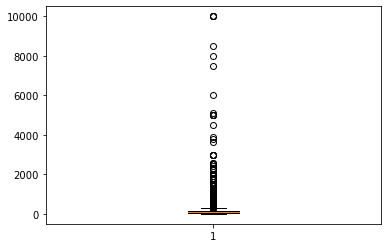

In [19]:
plt.boxplot(df_viz[['price']])
plt.show()

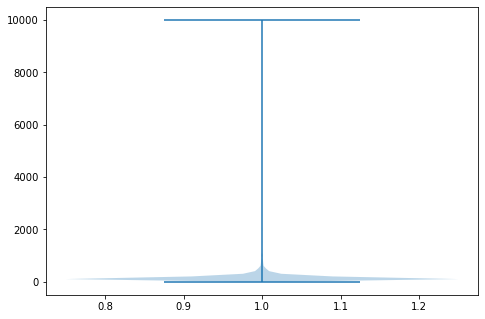

In [20]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(df_viz[['price']])
plt.show()

## Removing Outliers i.e. price > 250

In [21]:
df2 = df2.filter(df2.price<=250)

<AxesSubplot:>

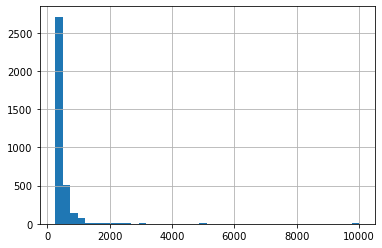

In [22]:
df_viz[df_viz['price']>250].price.hist(bins=40)

### Number of rows which can be removed

In [23]:
df_viz[df_viz['price']>250].price.value_counts().sum()

3520

### Distribution after removing outliers

<AxesSubplot:>

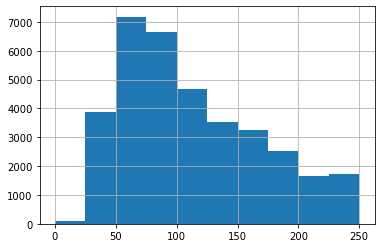

In [24]:
df_viz[df_viz['price']<=250].price.hist()

In [25]:
#Assuming that rentals would not be free
df2 = df2.filter(df2.price!=0)

In [26]:
df2.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string')]

## Encoding neighbourhood, room type and diff_in_days using Pipelines

String indexer and then one-hot encoding

In [27]:
ng_indexer = StringIndexer(inputCol="neighbourhood_group", outputCol="ng1")
n_indexer = StringIndexer(inputCol="neighbourhood", outputCol="n1")
rt_indexer = StringIndexer(inputCol="room_type", outputCol="rt1")
dfd_indexer = StringIndexer(inputCol="diff_in_days", outputCol="dfd1")

ng_onehot = OneHotEncoder(inputCol="ng1", outputCol="ngv")
n_onehot = OneHotEncoder(inputCol="n1", outputCol="nv")
rt_onehot = OneHotEncoder(inputCol="rt1", outputCol="rtv")
dfd_onehot = OneHotEncoder(inputCol="dfd1", outputCol="dfdv")

pipeline = Pipeline(stages=[ng_indexer, n_indexer, rt_indexer, dfd_indexer, \
                            ng_onehot, n_onehot, rt_onehot, dfd_onehot])
df3 = pipeline.fit(df2).transform(df2)
df3.show(5)

+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+---+----+---+----+-------------+----------------+-------------+-------------+
|neighbourhood_group|neighbourhood|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|latitude|longitude|  diff_in_days|ng1|  n1|rt1|dfd1|          ngv|              nv|          rtv|         dfdv|
+-------------------+-------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+--------+---------+--------------+---+----+---+----+-------------+----------------+-------------+-------------+
|           Brooklyn|   Kensington|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|         

In [28]:
df3.dtypes

[('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('room_type', 'string'),
 ('price', 'int'),
 ('minimum_nights', 'int'),
 ('number_of_reviews', 'int'),
 ('last_review', 'date'),
 ('reviews_per_month', 'float'),
 ('calculated_host_listings_count', 'int'),
 ('availability_365', 'int'),
 ('latitude', 'float'),
 ('longitude', 'float'),
 ('diff_in_days', 'string'),
 ('ng1', 'double'),
 ('n1', 'double'),
 ('rt1', 'double'),
 ('dfd1', 'double'),
 ('ngv', 'vector'),
 ('nv', 'vector'),
 ('rtv', 'vector'),
 ('dfdv', 'vector')]

## Vectorizing features

In [29]:
va = VectorAssembler(inputCols = \
                     ['minimum_nights', 'number_of_reviews', 'reviews_per_month', \
                      'calculated_host_listings_count', 'availability_365', \
                      'ngv','rtv', 'nv', 'dfdv', 'latitude', 'longitude'], outputCol = 'features')
df4 = va.transform(df3)
df4x = df4.select(['features', 'price'])
df4x.show(5)

+--------------------+-----+
|            features|price|
+--------------------+-----+
|(236,[0,1,2,3,4,5...|  149|
|(236,[0,1,2,3,4,6...|  225|
|(236,[0,1,2,3,4,5...|   89|
|(236,[0,1,2,3,6,1...|   80|
|(236,[0,1,2,3,4,6...|  200|
+--------------------+-----+
only showing top 5 rows



## MinMax Scaler

In [30]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(df4x)
df4 = scalerModel.transform(df4x)
df4.show(5)

+--------------------+-----+--------------------+
|            features|price|      scaledFeatures|
+--------------------+-----+--------------------+
|(236,[0,1,2,3,4,5...|  149|(236,[1,2,3,4,5,9...|
|(236,[0,1,2,3,4,6...|  225|(236,[1,2,3,4,6,1...|
|(236,[0,1,2,3,4,5...|   89|(236,[1,2,4,5,10,...|
|(236,[0,1,2,3,6,1...|   80|(236,[0,1,2,6,10,...|
|(236,[0,1,2,3,4,6...|  200|(236,[0,1,2,4,6,1...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [31]:
df4 = df4.select('scaledFeatures', 'price')
df4 = df4.withColumnRenamed("scaledFeatures","features")
df4 = df4.withColumnRenamed("price","label")
df4.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(236,[1,2,3,4,5,9...|  149|
|(236,[1,2,3,4,6,1...|  225|
+--------------------+-----+
only showing top 2 rows



In [32]:
#df4.repartition(1).write.parquet("file:///home/hduser/programs/processed_data.parquet")

In [33]:
df4 = spark.read.load("file:///home/hduser/programs/processed_data.parquet")
df4.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(236,[1,2,3,4,5,9...|  149|
|(236,[1,2,3,4,6,1...|  225|
|(236,[1,2,4,5,10,...|   89|
|(236,[0,1,2,6,10,...|   80|
|(236,[0,1,2,4,6,1...|  200|
+--------------------+-----+
only showing top 5 rows



## Train-Test split

In [34]:
splits = df4.randomSplit([0.7, 0.3], seed=12345)
train_df = splits[0]
test_df = splits[1]

In [35]:
#############################################################################################################

# Linear Regression without Feature Engineering

In [36]:
df3_raw = df.select('neighbourhood_group', 'neighbourhood', 'room_type', 'price', \
               'minimum_nights','number_of_reviews', 'reviews_per_month', \
               'calculated_host_listings_count', 'availability_365', 'latitude', 'longitude')

df3_raw = df3_raw.na.drop("any")

df3_raw = df3_raw.withColumn("price", df3_raw["price"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("minimum_nights", df3_raw["minimum_nights"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("number_of_reviews", df3_raw["number_of_reviews"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("reviews_per_month", df3_raw["reviews_per_month"].cast(FloatType()))
df3_raw = df3_raw.withColumn("calculated_host_listings_count", df3_raw["calculated_host_listings_count"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("availability_365", df3_raw["availability_365"].cast(IntegerType()))
df3_raw = df3_raw.withColumn("latitude", df3_raw["latitude"].cast(FloatType()))
df3_raw = df3_raw.withColumn("longitude", df3_raw["longitude"].cast(FloatType()))


df3_raw = df3_raw.na.drop("any")

pipeline = Pipeline(stages=[ng_indexer, n_indexer, rt_indexer, \
                            ng_onehot, n_onehot, rt_onehot])
df4_raw = pipeline.fit(df3_raw).transform(df3_raw)

va1 = VectorAssembler(inputCols = \
                     ['minimum_nights', 'number_of_reviews', 'reviews_per_month', \
                        'calculated_host_listings_count', 'availability_365', \
                      'ngv','rtv', 'nv', 'latitude', 'longitude'], outputCol = 'features')

df5_raw = va1.transform(df4_raw)
df5x_raw = df5_raw.select(['features', 'price'])

splits_raw = df5x_raw.randomSplit([0.7, 0.3], seed=12345)
train_df_raw = splits_raw[0]
test_df_raw = splits_raw[1]
#print(train_df_raw.collect()[5])

lr_raw = LinearRegression(featuresCol = 'features', labelCol='price')
lr_model_raw = lr_raw.fit(train_df_raw)
fullPredictions_raw = lr_model_raw.transform(test_df_raw).cache()
lr_evaluator_raw = RegressionEvaluator(predictionCol="prediction", labelCol="price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_raw.evaluate(fullPredictions_raw))
lr_evaluator_raw = RegressionEvaluator(predictionCol="prediction", labelCol="price",metricName="rmse")
print("RMSE (R2) on test data = %g" % lr_evaluator_raw.evaluate(fullPredictions_raw))

R Squared (R2) on test data = 0.13579
RMSE (R2) on test data = 184.575


# Linear Regression on Feature Engineered data

In [37]:
lr = LinearRegression(featuresCol = 'features', labelCol='label')
lr_model = lr.fit(train_df)
#print("Coefficients: " + str(lr_model.coefficients))
#print("Intercept: " + str(lr_model.intercept))

In [38]:
trainingSummary = lr_model.summary
print("Linear Regression RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Linear Regression R2: %f" % trainingSummary.r2)

Linear Regression RMSE: 36.695910
Linear Regression R2: 0.572002


In [39]:
# TEST Results
fullPredictions = lr_model.transform(test_df).cache()
print(fullPredictions)
fullPredictions.select("prediction","label","features").show(5)

DataFrame[features: vector, label: int, prediction: double]
+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|60.385936295341025|   58|(236,[0,1,2,3,4,5...|
| 77.52441716607314|  100|(236,[0,1,2,3,4,5...|
| 77.69777893877162|   55|(236,[0,1,2,3,4,5...|
| 65.99727643312633|   70|(236,[0,1,2,3,4,5...|
| 79.62035166823135|   85|(236,[0,1,2,3,4,5...|
+------------------+-----+--------------------+
only showing top 5 rows



In [40]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(fullPredictions))
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE (R2) on test data = %g" % lr_evaluator.evaluate(fullPredictions))
rmse = lr_evaluator.evaluate(fullPredictions)

R Squared (R2) on test data = 0.543713
RMSE (R2) on test data = 38.1893


In [41]:
"%2f"%rmse

'38.189284'

In [42]:
"{:.2f}".format(rmse)

'38.19'

# Linear Regression using HyperParameter Tuning

In [43]:
train, test = df4.randomSplit([0.7, 0.3], seed=2)

lr = LinearRegression(maxIter=10)

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# TrainValidationSplit will try all combinations of values and determine best model using
# the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# In this case the estimator is simply the linear regression.
# A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 70% of the data will be used for training, 30% for validation.
                           trainRatio=0.7)

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

# Make predictions on test data. model is the model with combination of parameters
# that performed best.
preds = model.transform(test)\
    .select("features", "label", "prediction")
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(preds))
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE (R2) on test data = %g" % lr_evaluator.evaluate(preds))

R Squared (R2) on test data = 0.559639
RMSE (R2) on test data = 37.2255


# Decision Tree Regressor

In [44]:
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='label')
dt_model = dt.fit(train_df)
dtPrediction = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % dt_evaluator.evaluate(dtPrediction))
dt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % dt_evaluator.evaluate(dtPrediction))

R Squared (R2) on test data = 0.538915
RMSE on test data = 38.3895


In [45]:
dtPrediction.show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|(236,[0,1,2,3,4,5...|   58|62.844041588909626|
|(236,[0,1,2,3,4,5...|  100|62.844041588909626|
|(236,[0,1,2,3,4,5...|   55|62.844041588909626|
|(236,[0,1,2,3,4,5...|   70| 65.37781350482315|
|(236,[0,1,2,3,4,5...|   85| 65.37781350482315|
+--------------------+-----+------------------+
only showing top 5 rows



# Gradiant Boosted Tree Regression

In [46]:
gb = GBTRegressor(featuresCol = 'features', labelCol='label')
gb_model = gb.fit(train_df)
gbPredictions = gb_model.transform(test_df)
gb_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % gb_evaluator.evaluate(gbPredictions))
gb_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % gb_evaluator.evaluate(gbPredictions))

R Squared (R2) on test data = 0.574731
RMSE on test data = 36.8684


In [47]:
gbPredictions.show(5)

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|(236,[0,1,2,3,4,5...|   58|68.63772242001687|
|(236,[0,1,2,3,4,5...|  100|72.56815920814375|
|(236,[0,1,2,3,4,5...|   55|69.09243621307623|
|(236,[0,1,2,3,4,5...|   70|66.00392874926567|
|(236,[0,1,2,3,4,5...|   85|73.05688692888373|
+--------------------+-----+-----------------+
only showing top 5 rows



# Random Forest Regressor

In [48]:
rf = RandomForestRegressor(featuresCol = 'features', labelCol='label')
rf_model = rf.fit(train_df)
rfPredictions = rf_model.transform(test_df)
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % rf_evaluator.evaluate(rfPredictions))
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % rf_evaluator.evaluate(rfPredictions))

R Squared (R2) on test data = 0.536821
RMSE on test data = 38.4766


In [49]:
rfPredictions.show(5)

+--------------------+-----+-----------------+
|            features|label|       prediction|
+--------------------+-----+-----------------+
|(236,[0,1,2,3,4,5...|   58|62.59849349979366|
|(236,[0,1,2,3,4,5...|  100|66.16618497997199|
|(236,[0,1,2,3,4,5...|   55|65.25218018440171|
|(236,[0,1,2,3,4,5...|   70|66.44927217651664|
|(236,[0,1,2,3,4,5...|   85|68.78455629419491|
+--------------------+-----+-----------------+
only showing top 5 rows



# Factorization machines Regressor

In [50]:
fm = FMRegressor(featuresCol = 'features', labelCol='label')
fm_model = fm.fit(train_df)
fmPredictions = fm_model.transform(test_df)
fm_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % fm_evaluator.evaluate(fmPredictions))
fm_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label",metricName="rmse")
print("RMSE on test data = %g" % fm_evaluator.evaluate(fmPredictions))

R Squared (R2) on test data = 0.548421
RMSE on test data = 37.9917


# Therefore GBT Regressor gave the best result